# Notebook 11_Multimodal Model

## ✅ Step 1: Load & Preprocess Data

In [11]:
import pandas as pd
import numpy as np

# Load energy data
energy_df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
energy_df.set_index('utc_timestamp', inplace=True)

# Load sentiment data
sentiment_df = pd.read_csv('../data/processed/final_sentiment_filtered_news.csv', parse_dates=['date'])
sentiment_df.rename(columns={'date': 'utc_timestamp'}, inplace=True)
sentiment_df['utc_timestamp'] = sentiment_df['utc_timestamp'].dt.floor('h')  # Round to nearest hour
sentiment_df.set_index('utc_timestamp', inplace=True)


# Aggregate hourly sentiment
avg_sentiment = sentiment_df.groupby('utc_timestamp').agg(
    avg_score=('sentiment_score', 'mean'),
    pos_ratio=('sentiment', lambda x: (x == 'POSITIVE').mean()),
    count=('sentiment', 'count')
)
# Keep only numeric columns
numeric_sentiment = avg_sentiment.select_dtypes(include='number')

# Resample to hourly (mean) and forward-fill
sentiment_hourly = numeric_sentiment.resample('h').mean().ffill()

In [86]:
# Load sentiment data
sentiment_num_df = pd.read_csv('../data/processed/filtered_energy_news_with_sentiment_numeric.csv', parse_dates=['date'])
sentiment_num_df.rename(columns={'date': 'utc_timestamp'}, inplace=True)
sentiment_num_df['utc_timestamp'] = sentiment_num_df['utc_timestamp'].dt.floor('h')  # Round to nearest hour
sentiment_num_df.set_index('utc_timestamp', inplace=True)

pivot_df = sentiment_df.pivot_table(
    index='utc_timestamp', 
    columns='category', 
    values='sentiment_score', 
    aggfunc='mean'
)
pivot_df.columns = [f"sentiment_{col}" for col in pivot_df.columns]

In [87]:
print(pivot_df)

                     sentiment_central banks  sentiment_europe  \
utc_timestamp                                                    
2015-01-02 14:00:00                      NaN          0.806550   
2015-01-03 04:00:00                      NaN               NaN   
2015-01-09 00:00:00                      NaN               NaN   
2015-01-12 01:00:00                      NaN          0.989828   
2015-01-13 18:00:00                      NaN          0.999584   
...                                      ...               ...   
2020-11-27 20:00:00                      NaN          0.947915   
2020-12-04 16:00:00                      NaN          0.939782   
2020-12-11 03:00:00                      NaN          0.931800   
2020-12-14 22:00:00                      NaN               NaN   
2020-12-15 20:00:00                 0.959827               NaN   

                     sentiment_impact  sentiment_middle east  \
utc_timestamp                                                  
2015-01-02 14

In [88]:
sentiment_hourly = sentiment_hourly.sort_index()

In [89]:
print(sentiment_hourly)

                     avg_score  pos_ratio  count
utc_timestamp                                   
2015-01-02 14:00:00   0.806550        0.0    1.0
2015-01-02 15:00:00   0.806550        0.0    1.0
2015-01-02 16:00:00   0.806550        0.0    1.0
2015-01-02 17:00:00   0.806550        0.0    1.0
2015-01-02 18:00:00   0.806550        0.0    1.0
...                        ...        ...    ...
2020-12-15 16:00:00   0.989593        0.0    1.0
2020-12-15 17:00:00   0.989593        0.0    1.0
2020-12-15 18:00:00   0.989593        0.0    1.0
2020-12-15 19:00:00   0.989593        0.0    1.0
2020-12-15 20:00:00   0.959827        1.0    1.0

[52183 rows x 3 columns]


In [90]:
print(energy_df)

                           cet_cest_timestamp  \
utc_timestamp                                   
2014-12-31 23:00:00  2015-01-01T00:00:00+0100   
2015-01-01 00:00:00  2015-01-01T01:00:00+0100   
2015-01-01 01:00:00  2015-01-01T02:00:00+0100   
2015-01-01 02:00:00  2015-01-01T03:00:00+0100   
2015-01-01 03:00:00  2015-01-01T04:00:00+0100   
...                                       ...   
2019-12-29 20:00:00  2019-12-29T21:00:00+0100   
2019-12-29 21:00:00  2019-12-29T22:00:00+0100   
2019-12-29 22:00:00  2019-12-29T23:00:00+0100   
2019-12-29 23:00:00  2019-12-30T00:00:00+0100   
2019-12-30 00:00:00  2019-12-30T01:00:00+0100   

                     DE_load_actual_entsoe_transparency  DE_solar_capacity  \
utc_timestamp                                                                
2014-12-31 23:00:00                                 NaN            37248.0   
2015-01-01 00:00:00                             41151.0            37248.0   
2015-01-01 01:00:00                             40

## ✅ Step 2: Merge & Clean

In [12]:
# Merge on timestamp
merged_df = energy_df.merge(sentiment_hourly, left_index=True, right_index=True, how='left')

# Drop if target missing
merged_df = merged_df.dropna(subset=['Price (EUR/MWhe)'])
print(merged_df.columns)

Index(['cet_cest_timestamp', 'DE_load_actual_entsoe_transparency',
       'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'Price (EUR/MWhe)', 'DE_temperature',
       'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal',
       'Gas_Price', 'Oil_Price', 'avg_score', 'pos_ratio', 'count'],
      dtype='object')


In [97]:
print(merged_df)

                           cet_cest_timestamp  \
utc_timestamp                                   
2015-01-01 00:00:00  2015-01-01T01:00:00+0100   
2015-01-01 01:00:00  2015-01-01T02:00:00+0100   
2015-01-01 02:00:00  2015-01-01T03:00:00+0100   
2015-01-01 03:00:00  2015-01-01T04:00:00+0100   
2015-01-01 04:00:00  2015-01-01T05:00:00+0100   
...                                       ...   
2019-12-29 20:00:00  2019-12-29T21:00:00+0100   
2019-12-29 21:00:00  2019-12-29T22:00:00+0100   
2019-12-29 22:00:00  2019-12-29T23:00:00+0100   
2019-12-29 23:00:00  2019-12-30T00:00:00+0100   
2019-12-30 00:00:00  2019-12-30T01:00:00+0100   

                     DE_load_actual_entsoe_transparency  DE_solar_capacity  \
utc_timestamp                                                                
2015-01-01 00:00:00                             41151.0            37248.0   
2015-01-01 01:00:00                             40135.0            37248.0   
2015-01-01 02:00:00                             39

## ✅ Step 3: Feature Engineering

In [25]:
from sklearn.model_selection import train_test_split

# Check which sentiment features were merged successfully
#sentiment_features = [col for col in merged_df.columns if col in ['sentiment_central banks', 'sentiment_europe',
#       'sentiment_impact', 'sentiment_middle east', 'sentiment_science']]
features = [
    'DE_solar_generation_actual',
    'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency',
    'Gas_Price',
    'Oil_Price',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal',
    'DE_temperature'
]
features += [
    'price_lag_24h', 
    'price_lag_168h',
    'price_roll_t48_t24',
    'price_roll_t192_t24',
    #'price_roll_24h', 
    #'price_roll_168h',
    'hour', 'dayofweek', 'month',
    'solar_load_ratio', 'wind_load_ratio', 'avg_score_lag_24h',
    'avg_score_lag_168h','avg_score_t48_t24',
    'avg_score_t192_t24'
]

# base_features = [
#     'price_lag_24h', 'price_lag_168h',
#     'hour', 'DE_load_actual_entsoe_transparency',
#     'wind_load_ratio', 'solar_load_ratio',
#     'avg_score_lag_24h','avg_score_roll_24h'
# ]
# features = base_features # + sentiment_features

# Add lag and rolling features
merged_df['avg_score_lag_24h'] = merged_df['avg_score'].shift(24)
merged_df['avg_score_lag_168h'] = merged_df['avg_score'].shift(168)
merged_df['avg_score_roll_24h'] = merged_df['avg_score'].rolling(24).mean()
merged_df['avg_score_roll_168h'] = merged_df['avg_score'].rolling(168).mean()

merged_df['avg_score_t48_t24'] = merged_df['avg_score'].shift(24).rolling(window=24).mean()
merged_df['avg_score_t192_t24'] = merged_df['avg_score'].shift(24).rolling(window=168).mean()
#merged_df['avg_score_roll_336h'] = merged_df['avg_score'].rolling(336).mean()

#merged_df['sentiment_central banks_lag_24'] = merged_df['sentiment_central banks'].shift(24)
#merged_df['sentiment_europe_lag_24'] = merged_df['sentiment_europe'].shift(24)
#merged_df['sentiment_impact_lag_24'] = merged_df['sentiment_impact'].shift(24)
#merged_df['sentiment_middle east_lag_24'] = merged_df['sentiment_middle east'].shift(24)
#merged_df['sentiment_science_lag_24'] = merged_df['sentiment_science'].shift(24)

merged_df['price_lag_1h'] = merged_df['Price (EUR/MWhe)'].shift(1)
merged_df['price_lag_24h'] = merged_df['Price (EUR/MWhe)'].shift(24)
merged_df['price_lag_168h'] = merged_df['Price (EUR/MWhe)'].shift(168)
merged_df['price_roll_24h'] = merged_df['Price (EUR/MWhe)'].rolling(24).mean()
merged_df['price_roll_168h'] = merged_df['Price (EUR/MWhe)'].rolling(168).mean()

merged_df['price_roll_t48_t24'] = merged_df['Price (EUR/MWhe)'].shift(24).rolling(window=24).mean()
merged_df['price_roll_t192_t24'] = merged_df['Price (EUR/MWhe)'].shift(24).rolling(window=168).mean()

# Calendar and ratio features
merged_df['hour'] = merged_df.index.hour
merged_df['dayofweek'] = merged_df.index.dayofweek
merged_df['month'] = merged_df.index.month
merged_df['solar_load_ratio'] = merged_df['DE_solar_generation_actual'] / merged_df['DE_load_actual_entsoe_transparency']
merged_df['wind_load_ratio'] = merged_df['DE_wind_generation_actual'] / merged_df['DE_load_actual_entsoe_transparency']

#merged_df[['sentiment_central banks', 'sentiment_europe','sentiment_impact', 'sentiment_middle east', 'sentiment_science']] = merged_df[['sentiment_central banks', 'sentiment_europe','sentiment_impact', 'sentiment_middle east', 'sentiment_science']].fillna(0)
# Final dataframe
final_df = merged_df[features + ['Price (EUR/MWhe)']].dropna()

# Train-test split
X = final_df[features]
y = final_df['Price (EUR/MWhe)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## ✅ Step 4: Split & Train Model

MAE: 6.24, RMSE: 8.52


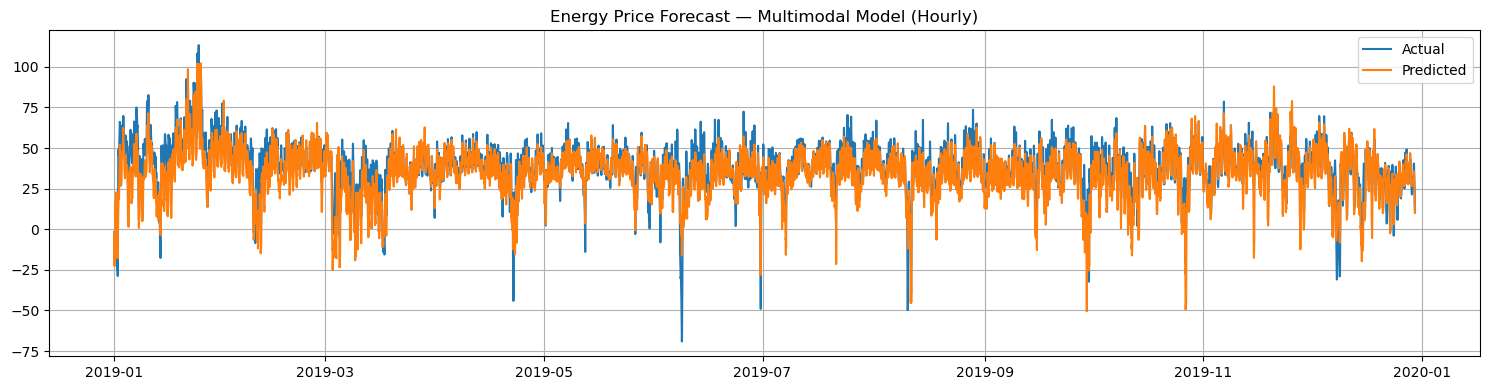

In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Train the model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # no squared=False

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(15, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Energy Price Forecast — Multimodal Model (Hourly)')
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Top Features by Importance:


,Feature,Importance
10,price_roll_24h,0.352073
16,wind_load_ratio,0.156936
9,price_lag_168h,0.085378
8,price_lag_24h,0.082829
15,solar_load_ratio,0.078493
2,DE_load_actual_entsoe_transparency,0.077542
12,hour,0.025406
13,dayofweek,0.020823
4,Oil_Price,0.016971
14,month,0.016447


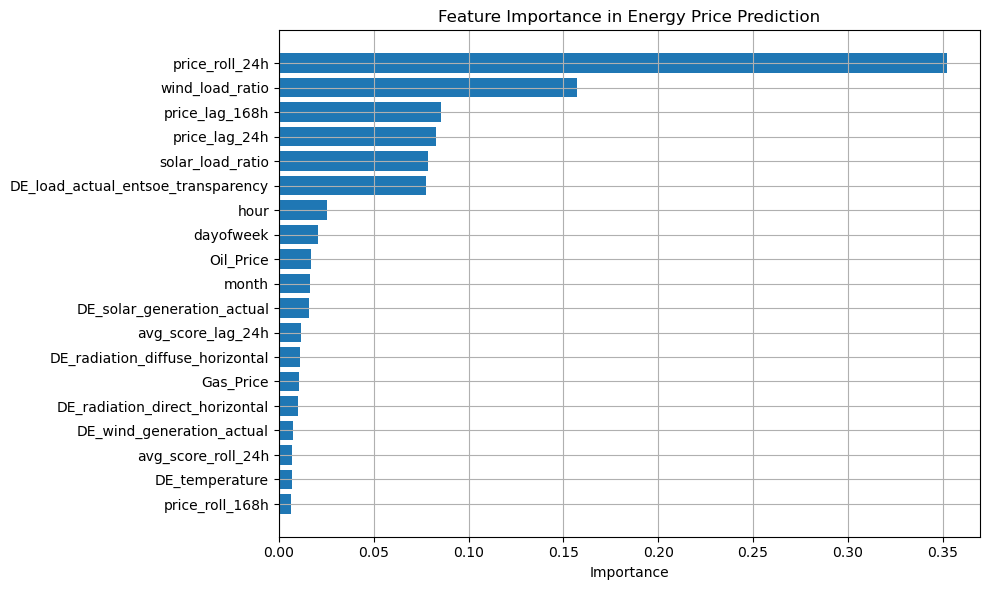

In [101]:
# Extract feature importance after training the model
importances = model.feature_importances_

# If you trained on df_model[features]
feature_names = features  # this is your list of selected input features

# Wrap into DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print("📊 Top Features by Importance:")
display(importance_df)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance in Energy Price Prediction")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()
